In [1]:
from __future__ import division, print_function, absolute_import

In [2]:
import time
from collections import OrderedDict

import tensorflow as tf

import pandas as pd

import numpy as np

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
cols = ['Ref', 'RefComposite', 'RhoHV', 'Zdr', 'Kdp']

df_raw = pd.read_csv('df_train.csv').set_index('Id')[cols+['minutes_past','Expected']]
ixs = np.array(df_raw.index.unique())
np.random.shuffle(ixs)
pivot = int(0.9*len(ixs))  # train_test splitting pivot
train_ixs, test_ixs = ixs[:pivot], ixs[pivot:]

df_train_raw = df_raw.loc[train_ixs,:]
df_test_raw = df_raw.loc[test_ixs,:]

df_train = df_train_raw.drop('minutes_past',1)
df_train.sample(5)

,Ref,RefComposite,RhoHV,Zdr,Kdp,Expected
Id,,,,,,
2752.0,20.000000,20.000000,0.815000,1.000000,1.059998,1.016000
3170.0,27.500000,38.000000,0.995000,0.437500,-1.410004,2.032001
2756.0,23.431635,25.146985,0.976558,0.604019,-0.027961,0.508000
2314.0,14.500000,20.500000,0.996667,0.750000,-0.530006,1.016000
299.0,23.431635,25.146985,0.976558,0.604019,-0.027961,14.000007


In [5]:
df_test = df_test_raw.drop('minutes_past',1)
df_test.head(5)

,Ref,RefComposite,RhoHV,Zdr,Kdp,Expected
Id,,,,,,
1643.0,26.0,26.0,0.958333,-0.5625,-1.059998,1.778001
1643.0,25.0,25.0,0.991667,0.4375,2.440002,1.778001
1643.0,21.0,26.5,0.978333,0.9375,1.059998,1.778001
1643.0,23.0,27.0,0.968333,0.3125,3.879990,1.778001
1643.0,28.0,28.0,0.971667,-0.5000,1.050003,1.778001


### Scaling the data

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler()
train_X = np.array(df_train.drop('Expected',1))
train_y = np.array(df_train['Expected'])

test_X = np.array(df_test.drop('Expected',1))
test_y = np.array(df_test['Expected'])

scaler.fit(train_X)
train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

In [8]:
df_train_scaled = pd.DataFrame(train_X,columns=cols, index=df_train.index)
df_train_scaled['Expected'] = df_train.Expected

df_test_scaled = pd.DataFrame(test_X,columns=cols, index=df_test.index)
df_test_scaled['Expected'] = df_test.Expected

### Generating batches

In [9]:
def next_id(df):
    ids = sorted(df.index.unique())
    while True:
        for i in ids:
            yield i

In [10]:
def df2instance(df, num_steps, labled):
    df = df.head(num_steps)
    instance = np.array(df)
    padding_width = num_steps-len(instance)
    instance = np.pad(instance, (0,padding_width), 'constant')
    if padding_width:
        instance = instance[:,:-padding_width]
    if labled:
        x, y = instance[:,:-1], instance[:,-1]
        return x,y
    else:
        return instance

In [11]:
def next_batch(df, batch_size=100, num_steps=10, labled=True):
    id_generator = next_id(df)
    while True:
        counter = 0
        seq_lens = list()
        batch_x, batch_y = list(), list()
        while counter<batch_size:
            id_ = id_generator.__next__()        
            batch_df = df.loc[id_]
            seq_lens.append(len(batch_df))
            counter += len(batch_df)
            
            x, y = df2instance(batch_df, num_steps, labled)
            batch_x.append(x)
            batch_y.append(y)
            
        yield np.array(batch_x), np.array(batch_y), np.array(seq_lens)

### Defining device cell wrappers

In [12]:
class DeviceCellWrapper(tf.contrib.rnn.RNNCell):
    def __init__(self, device, cell):
        self._cell = cell
        self._device = device

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return self._cell.output_size

    def __call__(self, inputs, state, scope=None):
        with tf.device(self._device):
            return self._cell(inputs, state, scope)

## Deep RNN
<img src="misc/deeprnn.png">

## Using traditional regression models

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

In [14]:
X = np.array(df_train_scaled.drop('Expected', 1))
y = np.array(df_train_scaled.Expected)

X_test = np.array(df_test_scaled.drop('Expected', 1))
y_test = np.array(df_test_scaled.Expected)

In [15]:
models = {"Linear Regression":LinearRegression,
          "RandomForest Regressor": RandomForestRegressor,
          "SVR":SVR}

In [16]:
for name,model in models.items():
    start = time.time()
    if 'SVR' in name:
        m = model(max_iter=1000)
    else:
        m = model(n_jobs=-1)
    m.fit(X,y)
    preds = m.predict(X_test)
    train_preds = m.predict(X)
    print("{0}:\nTrain MAE: {1}\nTest MAE: {2}\nTook: {3} seconds".format(
        name,
        mean_absolute_error(y, train_preds),
        mean_absolute_error(y_test, preds),
        time.time()-start))
    print()

Linear Regression:
Train MAE: 236.18594349170897
Test MAE: 248.44004583101616
Took: 0.007035493850708008 seconds

RandomForest Regressor:
Train MAE: 194.87638453408854
Test MAE: 210.42622906011567
Took: 0.5220174789428711 seconds



/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVR:
Train MAE: 1393.6109455846745
Test MAE: 1394.8274315574668
Took: 9.64234471321106 seconds



## Using 2 GRU layers
<img src='misc/gru.png'>

In [17]:
num_inputs = len(df_test.columns)-1
num_outputs = 1
num_units = 100
num_layers = 2
num_epochs = 100
batch_size=256

num_steps = int(df_train.groupby(df_train.index).count().max()[0])
num_steps

19

In [18]:
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('inputs'):
        X = tf.placeholder(tf.float32, [None, num_steps, num_inputs])
        Y = tf.placeholder(tf.float32, [None, num_steps, num_outputs])
        seq_lens = tf.placeholder(tf.int32, [None])
        keep_prob = tf.placeholder_with_default(1.0, shape=(), name='training')  # 0.5 in training, 1.0 in testing
        
    with tf.name_scope('gru_cells'):
        gru_cells = [tf.contrib.rnn.GRUCell(num_units) for i in range(num_layers)]
        
        gru_cells = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
                      for cell in gru_cells]
        deep_cell = tf.contrib.rnn.MultiRNNCell(gru_cells)
        
    with tf.name_scope("outputs"):
        outputs, states = tf.nn.dynamic_rnn(deep_cell, X, sequence_length=seq_lens, dtype=tf.float32)
        
        # Output projection
        stacked_rnn_outputs = tf.reshape(outputs, (-1, num_units))
        stacked_outputs = tf.contrib.layers.fully_connected(stacked_rnn_outputs, num_outputs, activation_fn=None)
        outputs = tf.reshape(stacked_outputs, (-1, num_steps, num_outputs))
    
    with tf.name_scope("optimization"):
        loss = tf.reduce_mean(tf.losses.absolute_difference(Y, outputs))
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
#         optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
        
    _saver = tf.train.Saver()
    init = tf.global_variables_initializer()    

In [19]:
g = next_batch(df_test_scaled, batch_size=len(df_test_scaled), num_steps=num_steps)
test_X, test_Y, test_seq_lens = g.__next__()
del g

In [20]:
start = time.time()
with tf.Session(graph=graph) as sess:
    with tf.device('/gpu'):
        init.run()
        batch_generator = next_batch(df_train_scaled, batch_size=batch_size, num_steps=num_steps)
        train_losses = OrderedDict()
        test_losses = OrderedDict()
        for e in range(num_epochs+1):
            avg_mae = 0
            for i in range(len(df_train)//batch_size):
                batch_X, batch_Y, batch_seq_lens = batch_generator.__next__()
                _, mae = sess.run([optimizer, loss],
                                  feed_dict={X:batch_X,
                                             Y:batch_Y.reshape(-1, num_steps, num_outputs),
                                             seq_lens: batch_seq_lens,
                                             keep_prob:0.5})
                
                avg_mae += mae
            train_losses[e] = avg_mae
            test_mae = sess.run([loss],
                                feed_dict={X:test_X,
                                           Y:test_Y.reshape(-1, num_steps, num_outputs),
                                           seq_lens:test_seq_lens,
                                           keep_prob:1.0})[0]
            test_losses[e] = test_mae
            print("Epoch {0}:\nTrain MAE: {1}\nTest MAE: {2}".format(e, avg_mae, test_mae))
            print("~"*30)
        test_preds = sess.run(outputs, {X:test_X,
                                           Y:test_Y.reshape(-1, num_steps, num_outputs),
                                           seq_lens:test_seq_lens,
                                           keep_prob:1.0})
        _saver.save(sess, './rain.s')
print("Took: ",time.time()-start)

Epoch 0:
Train MAE: 15384.256726861
Test MAE: 80.00251770019531
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1:
Train MAE: 15100.901099413633
Test MAE: 79.98652648925781
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2:
Train MAE: 15288.784970521927
Test MAE: 79.9847640991211
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3:
Train MAE: 15164.970030486584
Test MAE: 79.98226928710938
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4:
Train MAE: 15572.115158617496
Test MAE: 79.99211883544922
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5:
Train MAE: 15288.457538455725
Test MAE: 79.97898864746094
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 6:
Train MAE: 15487.883452475071
Test MAE: 79.97207641601562
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 7:
Train MAE: 15215.352372467518
Test MAE: 79.97560119628906
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 8:
Train MAE: 15352.97828578949
Test MAE: 79.98206329345703
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 9:
Train MAE: 15166.446332335472
Test MAE: 79.98411560058594
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 10:
Train MAE: 1510

Epoch 84:
Train MAE: 16369.553882658482
Test MAE: 79.96015167236328
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 85:
Train MAE: 15048.830881118774
Test MAE: 79.95968627929688
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 86:
Train MAE: 15134.926922291517
Test MAE: 79.9672622680664
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 87:
Train MAE: 15153.571388930082
Test MAE: 79.96332550048828
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 88:
Train MAE: 15246.69744861126
Test MAE: 79.96477508544922
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 89:
Train MAE: 15168.40379166603
Test MAE: 79.96127319335938
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 90:
Train MAE: 15400.466782987118
Test MAE: 79.97205352783203
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 91:
Train MAE: 15282.500079214573
Test MAE: 79.9612808227539
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 92:
Train MAE: 15226.782125473022
Test MAE: 79.9622802734375
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 93:
Train MAE: 14996.298562586308
Test MAE: 79.96350860595703
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 94:
Train

### Plotting results

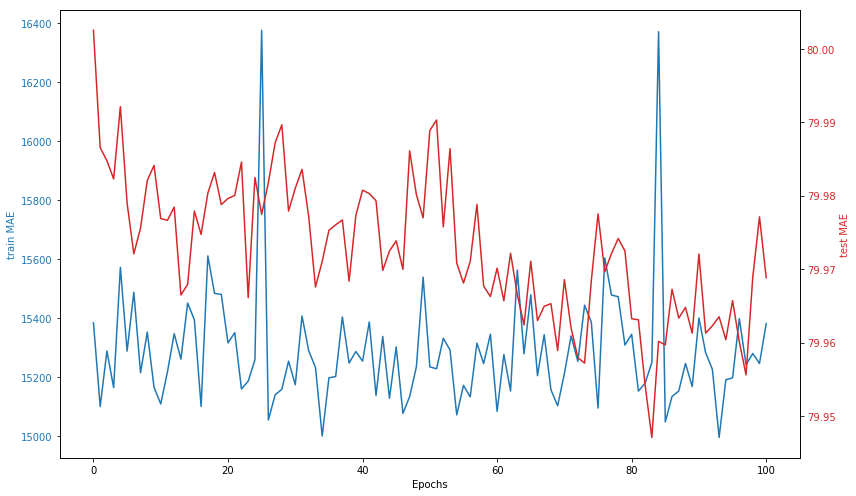

In [21]:
fig, ax1 = plt.subplots(figsize=(12,7))
xticks = sorted(train_losses.keys())
data1 = [train_losses[i] for i in xticks]
data2 = [test_losses[i] for i in xticks]

color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('train MAE', color=color)
ax1.plot(xticks, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('test MAE', color=color)
ax2.plot(xticks, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


In [22]:
x_ticks = df_test_raw.minutes_past/100+df_test_raw.index

In [23]:
indexed = df_test_raw.reset_index()

In [24]:
test_lables = np.concatenate([test_Y[i,:test_seq_lens[i]] for i in test_seq_lens])

In [25]:
preds = np.concatenate(
    [test_preds[i,:test_seq_lens[i],:] for i in test_seq_lens]).reshape(-1)

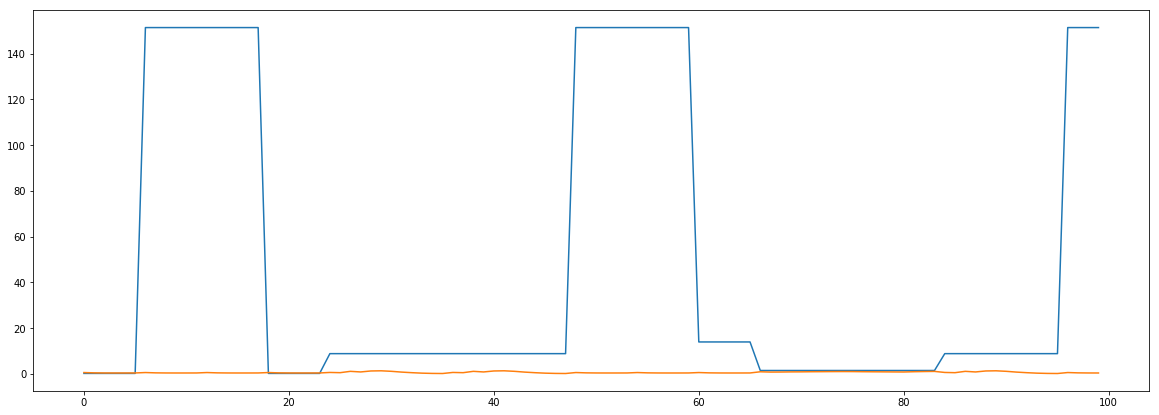

In [26]:
# x = np.array(indexed.index)
# y = np.array(indexed.Expected)
x = np.arange(len(test_lables))
plt.figure(figsize=(20,7))
plt.xticks = x_ticks
plt.plot(x[:100], test_lables[:100])
plt.plot(x[:100], preds[:100])
plt.show()